In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import pickle
import ast
import math 
import traceback
from sklearn import preprocessing
from ucimlrepo import fetch_ucirepo 

import seaborn as sns

2024-03-25 11:13:22.775147: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
dataset_name = "musk2"

In [118]:
# fetch dataset 
credit_approval = fetch_ucirepo(id=75) 
  
# data (as pandas dataframes) 
X = credit_approval.data.features 
y = credit_approval.data.targets 
  
# metadata 
print(credit_approval.metadata) 
  
# variable information 
print(credit_approval.variables) 

{'uci_id': 75, 'name': 'Musk (Version 2)', 'repository_url': 'https://archive.ics.uci.edu/dataset/75/musk+version+2', 'data_url': 'https://archive.ics.uci.edu/static/public/75/data.csv', 'abstract': 'The goal is to learn to predict whether new molecules will be musks or non-musks', 'area': 'Physics and Chemistry', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 6598, 'num_features': 166, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['class'], 'index_col': ['molecule_name', 'conformation_name'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Sat Mar 16 2024', 'dataset_doi': '10.24432/C51608', 'creators': ['David Chapman', 'Ajay Jain'], 'intro_paper': None, 'additional_info': {'summary': 'This dataset describes a set of 102 molecules of which 39 are judged by human experts to be musks and the remaining 63 molecules are judged to be non-musks.  The goal is to learn to predi

In [119]:
categorical_cols = []
# One-hot encode the categorical columns
df_encoded = pd.get_dummies(X, columns=categorical_cols)
# Initialize a scaler
scaler = preprocessing.StandardScaler()
# Fit and transform the data
X = pd.DataFrame(scaler.fit_transform(df_encoded), columns=df_encoded.columns)
X = X.fillna(0)
# to numpy
X = X.values

In [120]:
y = np.array([elem for elem in y["class"]])

In [121]:
from sklearn import model_selection

In [122]:
X, Xtest, y, ytest = model_selection.train_test_split(X, y)

In [123]:
y.mean()

0.1537995149555376

In [124]:
ytest.sum()

256.0

## Specify learning algorithms

In [125]:
import math


def sigmoid(x):
    x = np.clip(x, -200, 200)
    y = 1 / (1 + np.exp(-x))
    return y


def forward_logloss(X, theta):
    y = np.dot(X, theta.T)
    #print(f"{X=}")
    #print(f"{theta.T=}")
    #print(f"{y=}")
    y = sigmoid(y)
    #print(f"{y=}")
    return y


def backward_logloss(xx, yy, p):
    grad = (p - yy) * xx
    return grad


def cross_entropy(p, y, epsilon=1e-45):
    l = -np.mean(
        y * np.log(np.maximum(p, epsilon))
        + (1 - y) * np.log(np.maximum(1 - p, epsilon))
    )
    #print(f"{p=}")
    #print(f"{y=}")
    #print(f"{l=}")
    return l


def accuracy_prob(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    sp = np.sign(p - 1 / 2)
    a = (np.sign(sy * sp) + 1) / 2
    return np.mean(a)


def ratio(u):
    if u <= 10:
        y = ((1 + math.exp(u)) ** 2) * math.log(1 + math.exp(-u))
    else:
        y = math.exp(u)
    return y


def log_ratio(u):
    if u <= 10:
        y = ((1 + np.exp(u)) ** 2) * np.log1p(np.exp(-u))
        log_y = np.log(y)
    else:
        log_y = u
    return log_y


def update(theta, grad, eta=0.01, lam=2):
    newtheta = theta - eta * (grad + 0.5 * lam * theta)
    return newtheta

In [126]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss
accuracy = accuracy_prob

def train_model(
    X,
    y,
    Xtest,
    ytest,
    mode="rand",
    eta=0.01,
    lam=0,
    # Used in all the Polyak methods
    kappa=1,
    kappa0=0.1,
    # Used in Polyak and Polyak-bec
    polyakexp=1 / 2,
    # Used in polyak-becpi
    omega=1,
    # Added to enable non-adaptive stepsize experiments with pz != 1/2
    pz0 = 1/2,
    # For bec-minx1
    alpha = 1,
    x0 = 1,
    # multiplier to control sampling probability in bec-absloss
    prob_const = 1,
    # debug
    verbose=True,
    epsilon = 1e-45,
    max_iterations = 6600
):
    theta = np.zeros(X.shape[1])
    stheta = theta

    n_iterations = min(X.shape[0], max_iterations)  # Number of iterations
    #thetas = np.zeros((n_iterations, X.shape[1]))
    
    if verbose:
        print(f"Training with algorithm {mode}: {n_iterations} iterations with d={X.shape[1]}")
        
    losses = np.zeros(n_iterations)
    losses_reg = np.zeros(n_iterations)
    losses_test = np.zeros(n_iterations)
    losses_test_reg = np.zeros(n_iterations)
    accuracies = np.zeros(n_iterations)
    accuracies_test = np.zeros(n_iterations)
    labeled = np.zeros(n_iterations)
    #Delta = np.zeros(n_iterations)
    #sDelta = np.zeros(n_iterations)
    probs = np.zeros(n_iterations)
    #samples = []

    # for i in range(npoints):
    for i in range(n_iterations):
        xx = X[i, :]
        yy = y[i]

        p = 0
        q = 0
        pz = 1 / 2
        grad = 0

        if mode == "random":
            pz = pz0
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
        elif mode == "polyak_absloss":
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = omega / (1 + np.exp(u))
            pz = np.clip(pz, a_min=0, a_max=1)
            grad = zeta * grad / pz
        elif mode == "polyak_exponent": 
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            #zeta = kappa * (ratio(u) / (np.linalg.norm(xx) ** 2))
            zeta_log = math.log(kappa) + log_ratio(u) - math.log(np.linalg.norm(xx) ** 2)
            #zeta = math.exp(zeta_log)
            #zeta = min(zeta, kappa0)
            zeta = math.exp(min(zeta_log, math.log(kappa0)))
            pz = zeta ** polyakexp
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "polyak_exponent_old": 
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = zeta ** polyakexp
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "absloss":
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = 1 - np.exp(-bec)
            pz = omega * pz
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            grad = backward(xx, yy, p)
        elif mode == "minx1":  
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = np.min([(bec / x0) ** alpha, 1])
            grad = backward(xx, yy, p)
        elif mode == "polyak-minx1":
            # Binary cross-entropy loss with Polyak adaptive step size
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            grad = backward(xx, yy, p)
            
            # Compute pz as in bec-minx1 mode
            pz = np.min([(bec / x0) ** alpha, 1])

            # Compute u and zeta as in polyak-bec mode
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            
            # Compute the gradient of the binary cross-entropy loss with respect to theta
            dL_dpz = -(y / pz - (1 - y) / (1 - pz))
            dL_dbec = 0 if (bec / x0) > 1 else alpha * ((bec / x0) ** (alpha - 1)) / x0

            # Apply the Polyak adaptive step size to the gradient
            scaling_factor = zeta ** (1 - polyakexp)
            grad = scaling_factor * grad

        # sampling
        pz = np.clip(pz, epsilon, 1-epsilon)
        z = np.random.binomial(1, pz)
        #print(f"{p=}")
        #print(f"{yy=}")
        losses[i] = loss(p, yy)
        losses_reg[i] = losses[i] + lam * np.linalg.norm(theta)
        
        #stheta = (1 - 1 / (i + 1)) * stheta + (1 / (i + 1)) * theta
        accuracies[i] = accuracy(p, yy)

        labeled[i] = z
        probs[i] = pz
        # parameter update
        if z > 0:
            theta = update(theta, grad, eta=eta, lam=lam)
            #samples.append(i)

        """
        theta_norm = theta
        if np.linalg.norm(theta)>0:
          theta_norm = theta / np.linalg.norm(theta)
        Delta.append(np.linalg.norm(theta_norm-theta_star))

        stheta_norm = stheta
        if np.linalg.norm(stheta)>0:
          stheta_norm = stheta / np.linalg.norm(stheta)
        sDelta.append(np.linalg.norm(stheta_norm-theta_star))
        """

        p = forward(Xtest, theta)
        #print(f"{p=}")
        #print(f"{ytest=}")
        losses_test[i] = loss(p, ytest)
        losses_test_reg[i] = losses_test[i] + lam * np.linalg.norm(theta)
        accuracies_test[i] = accuracy(p, ytest)
        
        """
        p = forward(Xtest, stheta)
        ltest = loss(p, ytest) + lam * np.linalg.norm(stheta)
        slosses_test.append(ltest)
        """
        
        #p = forward(Xtest, theta)

        """
        p = forward(Xtest, stheta)
        a = accuracy(p, ytest)
        saccuracies_test.append(a)
        """

        if verbose and i % 10 == 0:
            print(f"loss: {losses_test[i]}, train loss: {losses[i]}, ||theta||_1: {np.sum(np.abs(theta))} acc: {accuracies[i]}")

    return {
        "losses": losses.tolist(),
        "losses_reg": losses_reg.tolist(),
        "losses_test": losses_test.tolist(),
        "losses_test_reg": losses_test_reg.tolist(),
        "labeled": labeled.tolist(),
        "theta": theta.tolist(),
        #"stheta": stheta,
        "probs": probs.tolist(),
        "accuracies": accuracies.tolist(),
        "accuracies_test": accuracies_test.tolist(),
        #"samples": samples.tolist(),
        #"thetas": thetas.tolist(),
    }

## Use best hyperparams to construct plot
We have stored results from our hyperparameter tuning run. Here we load the results file, and will use the best hyperparameters per method.

In [127]:
hyperparam_results = pd.read_csv("hyperparams_train_loss_zero_init_noreg_target050_eta300.csv", delimiter="\t", header=None)
hyperparam_results.columns = ["algorithm", "loss", "hyperparams"]

In [128]:
# Calculate best hyperparameters per method
min_losses = pd.DataFrame(hyperparam_results.groupby("algorithm").loss.min()).reset_index()
best_hyperparams = min_losses.merge(hyperparam_results, on=["algorithm", "loss"], how="left")

hyperparam_per_algo = {
    algorithm: ast.literal_eval(hyperparam) for 
    algorithm, hyperparam in 
    zip(best_hyperparams["algorithm"], best_hyperparams["hyperparams"])
}

In [129]:
hyperparam_per_algo["absloss"] = {"eta": 0.01}
hyperparam_per_algo["random"] = {"eta": 0.01}
hyperparam_per_algo["polyak_absloss"] |= {
    "eta": 0.01,
    "kappa": 10,
    "kappa0": 0.9,
    "omega": 1.0
}
hyperparam_per_algo["polyak_exponent"] |= {
    "eta": 0.01,
    "kappa": 10,
    "kappa0": 0.9,
    "omega": 1.10
}

In [130]:
hyperparam_per_algo

{'polyak_absloss': {'kappa': 10, 'kappa0': 0.9, 'eta': 0.01, 'omega': 1.0},
 'polyak_exponent': {'kappa': 10,
  'kappa0': 0.9,
  'eta': 0.01,
  'polyakexp': 0.9951814804061615,
  'omega': 1.1},
 'absloss': {'eta': 0.01},
 'random': {'eta': 0.01}}

# Plot 0: train loss of rand vs absloss (first run for absloss, then run for rand for matching pz)

- mean train loss curve
- mean test loss curve
- accuracy

In [131]:
absloss_params = hyperparam_per_algo["absloss"]

results_absloss = train_model(
    X, y, Xtest, ytest, mode="absloss", **absloss_params
)

Training with algorithm absloss: 4948 iterations with d=166
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.6733043331912512, train loss: 0.4644345823342981, ||theta||_1: 1.1622863807339705 acc: 1.0
loss: 0.7396579464134663, train loss: 1.2160499472002317, ||theta||_1: 1.8377610436480087 acc: 0.0
loss: 0.6736640864255693, train loss: 1.2394931689601298, ||theta||_1: 2.0205686270561563 acc: 0.0
loss: 0.6603286520636243, train loss: 1.5535074372471571, ||theta||_1: 2.1712764360607912 acc: 0.0
loss: 0.6790795398683, train loss: 0.7061003477899904, ||theta||_1: 2.4037811725850284 acc: 0.0
loss: 0.695983643201584, train loss: 0.5546222095831239, ||theta||_1: 2.619948833017121 acc: 1.0
loss: 0.7613049325270435, train loss: 0.6387464196128417, ||theta||_1: 3.157478722508473 acc: 1.0
loss: 0.7133698591860301, train loss: 1.1717635127070758, ||theta||_1: 3.0657851346241323 acc: 0.0
loss: 0.7173492264873023, train loss: 0.24710758287534113, ||theta||_1

loss: 0.5918807101623572, train loss: 1.3544842329904803, ||theta||_1: 7.152680936701765 acc: 0.0
loss: 0.6072295415920648, train loss: 1.1547874692323652, ||theta||_1: 7.054098921768453 acc: 0.0
loss: 0.6021686842832046, train loss: 0.38088609075106367, ||theta||_1: 7.2255785138477115 acc: 1.0
loss: 0.6219765305258588, train loss: 0.17810663662575524, ||theta||_1: 7.2765974233955415 acc: 1.0
loss: 0.6566584429984417, train loss: 1.4228606139146112, ||theta||_1: 7.408699009031883 acc: 0.0
loss: 0.6148359578613085, train loss: 0.687302187614159, ||theta||_1: 7.13330627728695 acc: 1.0
loss: 0.622833640906713, train loss: 0.8509887029731958, ||theta||_1: 7.0985009494459295 acc: 0.0
loss: 0.6128482332280812, train loss: 0.4131086373360008, ||theta||_1: 7.232480818186422 acc: 1.0
loss: 0.6236298246648189, train loss: 0.4051559005766566, ||theta||_1: 7.35116312991845 acc: 1.0
loss: 0.6428905486664319, train loss: 0.7204892849384763, ||theta||_1: 7.245765434855995 acc: 0.0
loss: 0.61243823396

loss: 0.6314255366215428, train loss: 0.3570326877717768, ||theta||_1: 9.206055833350348 acc: 1.0
loss: 0.6982478278982583, train loss: 1.151274565097244, ||theta||_1: 9.276651974230115 acc: 0.0
loss: 0.6035170461875744, train loss: 0.2643278002705757, ||theta||_1: 9.318748915315126 acc: 1.0
loss: 0.5927997593929069, train loss: 0.5821779580037066, ||theta||_1: 9.436039411481406 acc: 1.0
loss: 0.612694663384362, train loss: 0.1493532030001309, ||theta||_1: 9.509539605096846 acc: 1.0
loss: 0.6122770682280684, train loss: 0.6555514365472134, ||theta||_1: 9.383132416584422 acc: 1.0
loss: 0.628718062150926, train loss: 0.4365171100421923, ||theta||_1: 9.417497510676876 acc: 1.0
loss: 0.5775792545612903, train loss: 1.3188908576861658, ||theta||_1: 9.06451771191577 acc: 0.0
loss: 0.6076514269060523, train loss: 1.2863063738125808, ||theta||_1: 9.090190989544672 acc: 0.0
loss: 0.6478229824113152, train loss: 0.042144637416715, ||theta||_1: 9.104265817985212 acc: 1.0
loss: 0.6324590399080124,

loss: 0.6094490914947399, train loss: 0.21379545508254447, ||theta||_1: 11.650397514283778 acc: 1.0
loss: 0.5992375563180379, train loss: 0.5224430906148888, ||theta||_1: 11.642531874134272 acc: 1.0
loss: 0.6048659268139616, train loss: 0.4100564027813486, ||theta||_1: 11.610014301520726 acc: 1.0
loss: 0.5860896849568805, train loss: 0.6792891293274848, ||theta||_1: 11.738910143941375 acc: 1.0
loss: 0.5738828441010052, train loss: 0.929478278730729, ||theta||_1: 11.734145057707128 acc: 0.0
loss: 0.6079745239830019, train loss: 0.15754369172467064, ||theta||_1: 11.653029275461815 acc: 1.0
loss: 0.6706227376528268, train loss: 0.5355552398618133, ||theta||_1: 11.75493024291739 acc: 1.0
loss: 0.6540911255539348, train loss: 0.8487608515383053, ||theta||_1: 11.810249150226952 acc: 0.0
loss: 0.7526529997635162, train loss: 1.173476971174184, ||theta||_1: 11.982818987307962 acc: 0.0
loss: 0.6019362348342109, train loss: 0.8440889061102392, ||theta||_1: 12.045515952532085 acc: 0.0
loss: 0.591

In [132]:
absloss_mean_sampling_prob = np.mean(results_absloss["probs"])

In [133]:
absloss_mean_sampling_prob

0.42289001225582845

In [134]:
rand_params = hyperparam_per_algo["random"]

results_rand = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(rand_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 4948 iterations with d=166
loss: 0.7004326003425484, train loss: 0.6931471805599453, ||theta||_1: 0.5541089730234586 acc: 0.5
loss: 0.7516479633920156, train loss: 0.39022070635254374, ||theta||_1: 1.664099376975062 acc: 1.0
loss: 0.7994980598398481, train loss: 1.194947543750163, ||theta||_1: 2.2356298272759245 acc: 0.0
loss: 0.7580840920745943, train loss: 1.4719041142751692, ||theta||_1: 2.3475457583581827 acc: 0.0
loss: 0.6973594049220047, train loss: 1.4342778907759863, ||theta||_1: 2.368661602111155 acc: 0.0
loss: 0.6906252345951732, train loss: 1.7319823386307955, ||theta||_1: 2.9010442199594078 acc: 0.0
loss: 0.7639015699271149, train loss: 0.25827787935716373, ||theta||_1: 3.5993460703035334 acc: 1.0
loss: 0.6811525342701061, train loss: 0.9620553911028706, ||theta||_1: 2.547804960376702 acc: 0.0
loss: 0.6964960878979899, train loss: 0.6682987974774953, ||theta||_1: 2.6313723246404277 acc: 1.0
loss: 0.6890400752283398, train loss: 1.037975572651

loss: 0.6714836943844119, train loss: 1.4473031045382418, ||theta||_1: 8.76932912953936 acc: 0.0
loss: 0.6793765529563001, train loss: 0.46572746374905144, ||theta||_1: 8.751462327632899 acc: 1.0
loss: 0.6292591649023067, train loss: 0.2674947157711286, ||theta||_1: 8.970205106743903 acc: 1.0
loss: 0.6113042575650461, train loss: 0.025701051678080872, ||theta||_1: 9.129612679701571 acc: 1.0
loss: 0.6243669831818506, train loss: 0.48864577293031247, ||theta||_1: 9.047160936941086 acc: 1.0
loss: 0.612204867940051, train loss: 1.3716782501376916, ||theta||_1: 9.106105513039694 acc: 0.0
loss: 0.6386861857403312, train loss: 0.16749060270027363, ||theta||_1: 9.299907513240772 acc: 1.0
loss: 0.61115354940114, train loss: 0.5411083447260026, ||theta||_1: 9.432281262578963 acc: 1.0
loss: 0.6001477440480145, train loss: 0.4452367845488187, ||theta||_1: 9.47217660294342 acc: 1.0
loss: 0.654950342003646, train loss: 0.12470810237014035, ||theta||_1: 9.732945544212532 acc: 1.0
loss: 0.627330784649

loss: 0.6742214342745696, train loss: 0.40349218387221136, ||theta||_1: 12.224250108369452 acc: 1.0
loss: 0.6953344209948019, train loss: 0.9224797835530189, ||theta||_1: 12.30719722927254 acc: 0.0
loss: 0.734670531971171, train loss: 0.17092995455369633, ||theta||_1: 12.463575677193287 acc: 1.0
loss: 0.6300621834081758, train loss: 0.1853575634343857, ||theta||_1: 12.507090047013339 acc: 1.0
loss: 0.6347320511632593, train loss: 0.057406676884005255, ||theta||_1: 12.526202368954596 acc: 1.0
loss: 0.662143250382927, train loss: 0.1982885901003515, ||theta||_1: 12.469898620065507 acc: 1.0
loss: 0.6905953247067909, train loss: 0.04609440421244344, ||theta||_1: 12.456309917899635 acc: 1.0
loss: 0.6822896455173555, train loss: 0.3228595499179935, ||theta||_1: 12.408133773508762 acc: 1.0
loss: 0.7195519320708087, train loss: 0.7931078992342763, ||theta||_1: 12.36264656444784 acc: 0.0
loss: 0.6623436212795876, train loss: 0.6948797987121879, ||theta||_1: 12.507428364278248 acc: 0.0
loss: 0.6

loss: 0.6070348879161063, train loss: 1.8574880307021397, ||theta||_1: 13.829095757089613 acc: 0.0
loss: 0.6086441061918563, train loss: 0.9466048121023876, ||theta||_1: 13.868090150074545 acc: 0.0
loss: 0.6350754721214352, train loss: 0.21094153493064902, ||theta||_1: 13.796595201131353 acc: 1.0
loss: 0.5810032541100226, train loss: 1.162398682211041, ||theta||_1: 13.738048982547873 acc: 0.0
loss: 0.5926394569920812, train loss: 0.17500909275103502, ||theta||_1: 13.633422240204638 acc: 1.0
loss: 0.5808643818428122, train loss: 0.4102624291376862, ||theta||_1: 13.705678705033797 acc: 1.0
loss: 0.5959035088387494, train loss: 0.0018808806209794555, ||theta||_1: 13.84748613106981 acc: 1.0
loss: 0.6320091359535741, train loss: 1.000108786574605, ||theta||_1: 13.787669147810126 acc: 0.0
loss: 0.5892798473304312, train loss: 0.1626360944739385, ||theta||_1: 13.788019441135337 acc: 1.0
loss: 0.5812659349372258, train loss: 0.3824058819693088, ||theta||_1: 13.70133106451307 acc: 1.0
loss: 0.5

In [135]:
results_rand_absloss_params = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(absloss_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 4948 iterations with d=166
loss: 0.7004326003425484, train loss: 0.6931471805599453, ||theta||_1: 0.5541089730234586 acc: 0.5
loss: 0.7221954330388665, train loss: 0.4165486873194941, ||theta||_1: 0.9670275866419396 acc: 1.0
loss: 0.8251109308317598, train loss: 0.8366622350455526, ||theta||_1: 2.0806937396159446 acc: 0.0
loss: 0.6808759277239895, train loss: 1.1424209433640253, ||theta||_1: 1.9630881142837544 acc: 0.0
loss: 0.6919731183789163, train loss: 1.1196091152773415, ||theta||_1: 1.8590248879240743 acc: 0.0
loss: 0.7904691836691334, train loss: 0.4308063676241252, ||theta||_1: 2.318829342049233 acc: 1.0
loss: 0.6784606284817418, train loss: 0.6950365284612003, ||theta||_1: 2.498056677006998 acc: 0.0
loss: 0.7492474796971837, train loss: 1.0170197448569727, ||theta||_1: 2.3338352947287744 acc: 0.0
loss: 0.797067494685689, train loss: 0.20107986862170593, ||theta||_1: 2.6029068510248807 acc: 1.0
loss: 0.7489599065283662, train loss: 0.722611258005

loss: 0.652985290877955, train loss: 0.04328984621088245, ||theta||_1: 10.280790461876816 acc: 1.0
loss: 0.6706064195282307, train loss: 0.022613078751663473, ||theta||_1: 10.318216170764558 acc: 1.0
loss: 0.670654478106717, train loss: 1.363263916471873, ||theta||_1: 10.179916091727659 acc: 0.0
loss: 0.6427035290142703, train loss: 1.327775612531634, ||theta||_1: 10.23200702842281 acc: 0.0
loss: 0.6412572098574071, train loss: 0.10211416179220367, ||theta||_1: 10.313984496334992 acc: 1.0
loss: 0.6581552845328602, train loss: 0.1845709579232906, ||theta||_1: 10.488882500416143 acc: 1.0
loss: 0.6329606977120762, train loss: 0.49396156719179807, ||theta||_1: 10.291875653605318 acc: 1.0
loss: 0.6329219881958336, train loss: 0.1764736079425584, ||theta||_1: 10.387566880300845 acc: 1.0
loss: 0.6409660493792935, train loss: 0.5720391698941163, ||theta||_1: 10.42447963135368 acc: 1.0
loss: 0.657027183917032, train loss: 0.562960012216961, ||theta||_1: 10.207374349253744 acc: 1.0
loss: 0.68255

loss: 0.860525308949781, train loss: 0.11316271795630763, ||theta||_1: 12.68911128628421 acc: 1.0
loss: 0.603055340305852, train loss: 0.3684684564820857, ||theta||_1: 12.262097169547417 acc: 1.0
loss: 0.5976844963905592, train loss: 0.9941804512621214, ||theta||_1: 12.305587422295218 acc: 0.0
loss: 0.5881016242293374, train loss: 0.378808745197503, ||theta||_1: 12.454002802398694 acc: 1.0
loss: 0.5964311577052412, train loss: 0.15797433326422303, ||theta||_1: 12.52764790733203 acc: 1.0
loss: 0.5961450258094698, train loss: 0.5971668809405734, ||theta||_1: 12.61403612003329 acc: 1.0
loss: 0.6589934919846352, train loss: 0.4031017309982441, ||theta||_1: 12.600186522332782 acc: 1.0
loss: 0.714184166066973, train loss: 0.3456367308370829, ||theta||_1: 12.715966700252189 acc: 1.0
loss: 0.7796145891777688, train loss: 0.7817948097303795, ||theta||_1: 12.736860263403631 acc: 0.0
loss: 0.6037253648975148, train loss: 0.6874942403953962, ||theta||_1: 12.627762583382996 acc: 1.0
loss: 0.6441179

loss: 0.6485729027453325, train loss: 0.007981134341208816, ||theta||_1: 16.24629222957131 acc: 1.0
loss: 0.6833233028796915, train loss: 0.7597877504578809, ||theta||_1: 15.96515406622025 acc: 0.0
loss: 0.6981987258810807, train loss: 0.1858512435607572, ||theta||_1: 15.998280261685036 acc: 1.0
loss: 0.6518365845532986, train loss: 0.7617376446168354, ||theta||_1: 16.251875939684172 acc: 0.0
loss: 0.6281502220381583, train loss: 0.4808492767211432, ||theta||_1: 16.02759149806645 acc: 1.0
loss: 0.6674555893867433, train loss: 0.1950414288585718, ||theta||_1: 16.10532541985351 acc: 1.0
loss: 0.6503194189732329, train loss: 1.0201135456974555, ||theta||_1: 16.191465974393296 acc: 0.0
loss: 0.6069999216804746, train loss: 1.540910166135617, ||theta||_1: 16.052102288117958 acc: 0.0
loss: 0.591388321652046, train loss: 0.20758510069757038, ||theta||_1: 16.017549768755522 acc: 1.0
loss: 0.5914945919504933, train loss: 0.34418944712993926, ||theta||_1: 16.018860228405856 acc: 1.0
loss: 0.5846

In [136]:
results_absloss_rand_params = train_model(
    X, y, Xtest, ytest, mode="absloss", verbose=True, **rand_params
)

Training with algorithm absloss: 4948 iterations with d=166
loss: 0.7004326003425484, train loss: 0.6931471805599453, ||theta||_1: 0.5541089730234586 acc: 0.5
loss: 0.7123184955207574, train loss: 0.837239568519579, ||theta||_1: 0.7393797561110338 acc: 0.0
loss: 0.729452742594547, train loss: 0.6052696741418859, ||theta||_1: 1.2738321061220281 acc: 1.0
loss: 0.7054011128516526, train loss: 0.86933955695378, ||theta||_1: 1.657946723026123 acc: 0.0
loss: 0.7124084453493872, train loss: 1.2188403133931542, ||theta||_1: 1.9948834023109407 acc: 0.0
loss: 0.6643169151502215, train loss: 0.7576426460251897, ||theta||_1: 2.2382625700828833 acc: 0.0
loss: 0.6854197538747653, train loss: 0.39401234310794964, ||theta||_1: 2.576090801042416 acc: 1.0
loss: 0.6809455961903753, train loss: 0.7935132143630035, ||theta||_1: 2.42789451445332 acc: 0.0
loss: 0.7105215898979832, train loss: 0.6224366231510425, ||theta||_1: 2.9541764343373558 acc: 1.0
loss: 0.6780436881517656, train loss: 0.6489121292913032

loss: 0.6022921391654864, train loss: 1.6496018278949178, ||theta||_1: 7.665440788117477 acc: 0.0
loss: 0.6207395719461472, train loss: 1.3131538879699904, ||theta||_1: 7.717272909086047 acc: 0.0
loss: 0.6021303246117874, train loss: 0.6602290642193354, ||theta||_1: 7.839530399864022 acc: 1.0
loss: 0.6172287637632726, train loss: 0.1348850137246577, ||theta||_1: 7.910432302739121 acc: 1.0
loss: 0.6033052978513191, train loss: 0.2804911150661603, ||theta||_1: 7.778423134065732 acc: 1.0
loss: 0.6102338071231445, train loss: 0.8828482905933679, ||theta||_1: 7.926559254733732 acc: 0.0
loss: 0.6142393772239068, train loss: 0.4265071346128254, ||theta||_1: 7.750977911313061 acc: 1.0
loss: 0.6066844351815329, train loss: 1.2408508948789507, ||theta||_1: 7.750816020377783 acc: 0.0
loss: 0.6169498335308472, train loss: 0.6837799231281511, ||theta||_1: 7.932541561021343 acc: 1.0
loss: 0.6322951782453988, train loss: 0.4226743420550072, ||theta||_1: 8.02474180425924 acc: 1.0
loss: 0.6557944204060

loss: 0.6177594348044151, train loss: 0.5087564554426303, ||theta||_1: 9.402153408195144 acc: 1.0
loss: 0.6017572458182383, train loss: 0.4767078910163265, ||theta||_1: 9.444475371603811 acc: 1.0
loss: 0.5937481350274746, train loss: 0.7511243820691335, ||theta||_1: 9.76735109768078 acc: 0.0
loss: 0.6354474535214266, train loss: 0.9204701252136908, ||theta||_1: 9.914942549038775 acc: 0.0
loss: 0.5789599892819499, train loss: 0.41664994787921916, ||theta||_1: 9.976157589669034 acc: 1.0
loss: 0.5861544267092766, train loss: 0.5283880088578221, ||theta||_1: 10.061359466864321 acc: 1.0
loss: 0.5791297810438853, train loss: 0.5670870230632812, ||theta||_1: 10.008543529218882 acc: 1.0
loss: 0.5791683047067606, train loss: 0.5246572710447687, ||theta||_1: 10.035235340000224 acc: 1.0
loss: 0.6028746175051892, train loss: 0.16387369726019196, ||theta||_1: 10.068863546244707 acc: 1.0
loss: 0.5861342019600662, train loss: 0.40255851199100245, ||theta||_1: 10.009470208704661 acc: 1.0
loss: 0.59903

loss: 0.6066818613299211, train loss: 0.46622586459630627, ||theta||_1: 11.831114479904368 acc: 1.0
loss: 0.5747421232847751, train loss: 0.17803976904020413, ||theta||_1: 12.006471098245665 acc: 1.0
loss: 0.6141969010377666, train loss: 0.7384347486906319, ||theta||_1: 11.867003212305104 acc: 0.0
loss: 0.6204764528678091, train loss: 0.9343871285857624, ||theta||_1: 11.892833080052085 acc: 0.0
loss: 0.6054062370764328, train loss: 0.2737113325743805, ||theta||_1: 12.012363940979984 acc: 1.0
loss: 0.6188621334625479, train loss: 0.23657378590648767, ||theta||_1: 11.935970420933629 acc: 1.0
loss: 0.6377258622344564, train loss: 0.028384465588365285, ||theta||_1: 11.98621096704121 acc: 1.0
loss: 0.6052144532686894, train loss: 0.8066674142251861, ||theta||_1: 11.926989405544134 acc: 0.0
loss: 0.6120235873183295, train loss: 0.5476694840049416, ||theta||_1: 12.045058920804152 acc: 1.0
loss: 0.6134378087587313, train loss: 0.5285263916448497, ||theta||_1: 11.877869870859834 acc: 1.0
loss: 

In [137]:
def results_to_df(results):
    dfs = []
    for k, v in results.items():
        df = pd.DataFrame(
            {
                "train_loss": v["losses"],
                "train_loss_reg": v["losses_reg"],
                "test_loss": v["losses_test"],
                "test_loss_reg": v["losses_test_reg"],
                "iteration": range(1, len(v["losses"]) + 1),
                "labeled": v["labeled"],
                "probs": v["probs"],
                "train_accuracy": v["accuracies"],
                "test_accuracy": v["accuracies_test"],
            }
        )
        df["method"] = k
        df["mean_train_loss"] = np.cumsum(df.train_loss) / df.iteration
        df["mean_test_loss"] = np.cumsum(df.test_loss) / df.iteration
        df["mean_test_accuracy"] = np.cumsum(df.test_accuracy) / df.iteration
        df["mean_train_accuracy"] = np.cumsum(df.train_accuracy) / df.iteration
        df["cost"] = np.cumsum(df.labeled)
        dfs += [df]   
    
    return pd.concat(dfs, axis=0)

results_df = results_to_df(
    {
        "absloss": results_absloss,
        "random": results_rand,
        "random_with_absloss_params": results_rand_absloss_params,
        "absloss_with_random_params": results_absloss_rand_params,
    }
)

(0.0, 1000.0)

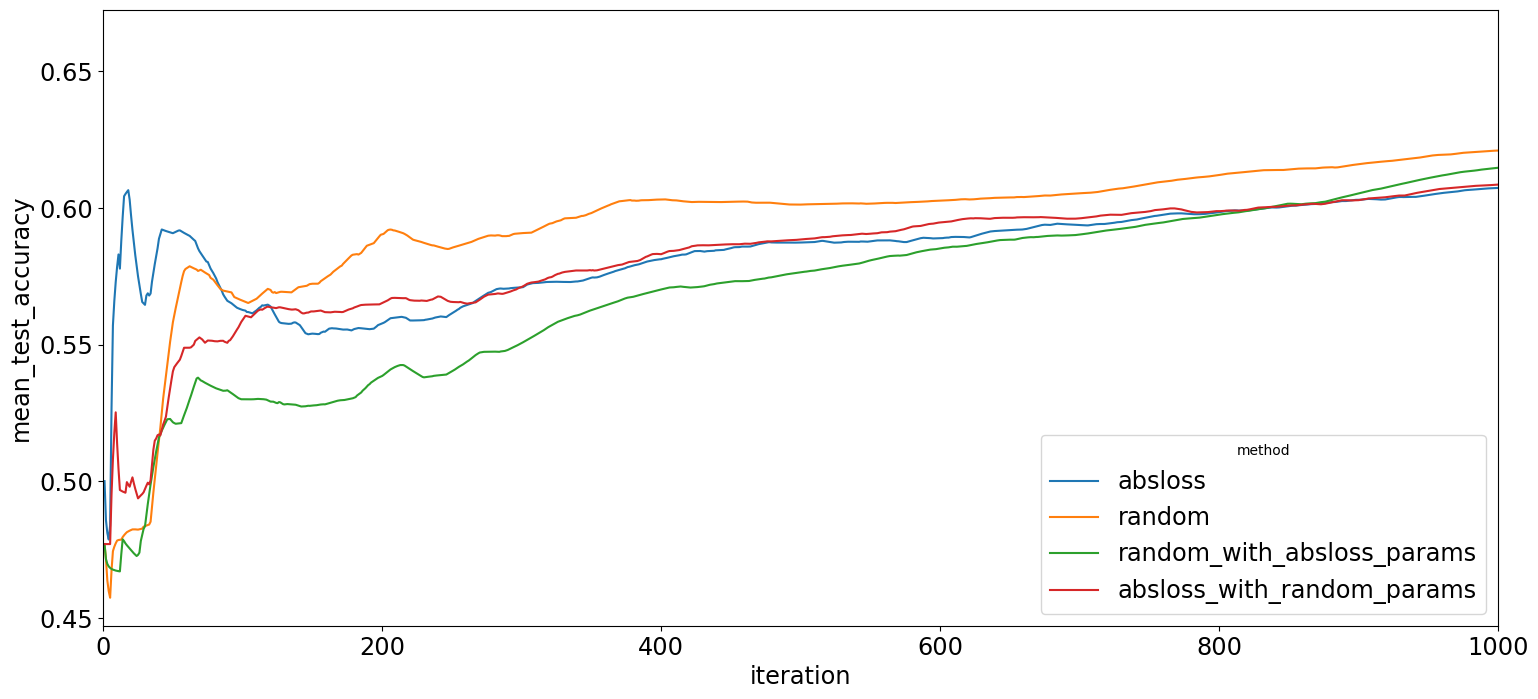

In [138]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(
    data=results_df,#results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_test_accuracy",
    hue="method"
)

ax.set_xlim((0, 1000))

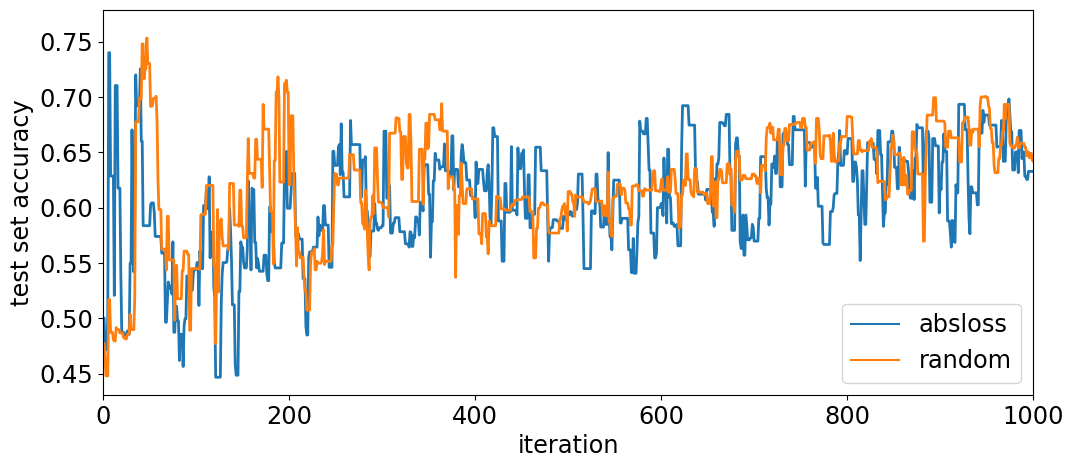

In [139]:
plt.figure(figsize=(12,5))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="test_accuracy",
    hue="method",
    linewidth=2
)

legend = ax.get_legend()
legend.set_title('')

ax.set(ylabel="test set accuracy")
sns.move_legend(ax, "lower right")

ax.set_xlim((0, 1000))

plt.savefig(f"figure_8a_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

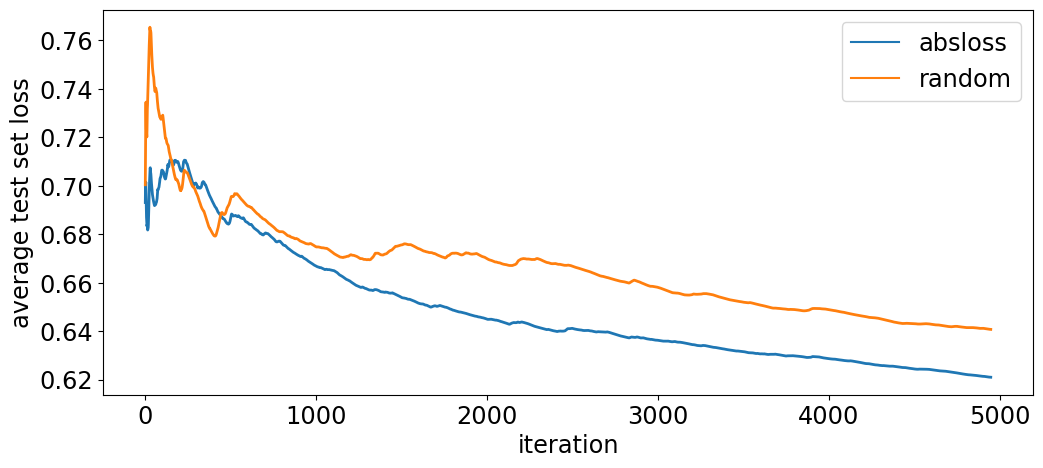

In [140]:
plt.figure(figsize=(12,5))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_test_loss",
    hue="method",
    linewidth=2
)
ax.set(ylabel="average test set loss")
legend = ax.get_legend()
legend.set_title('')

plt.savefig(f"figure_7a_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

Text(0, 0.5, 'average cross entropy loss')

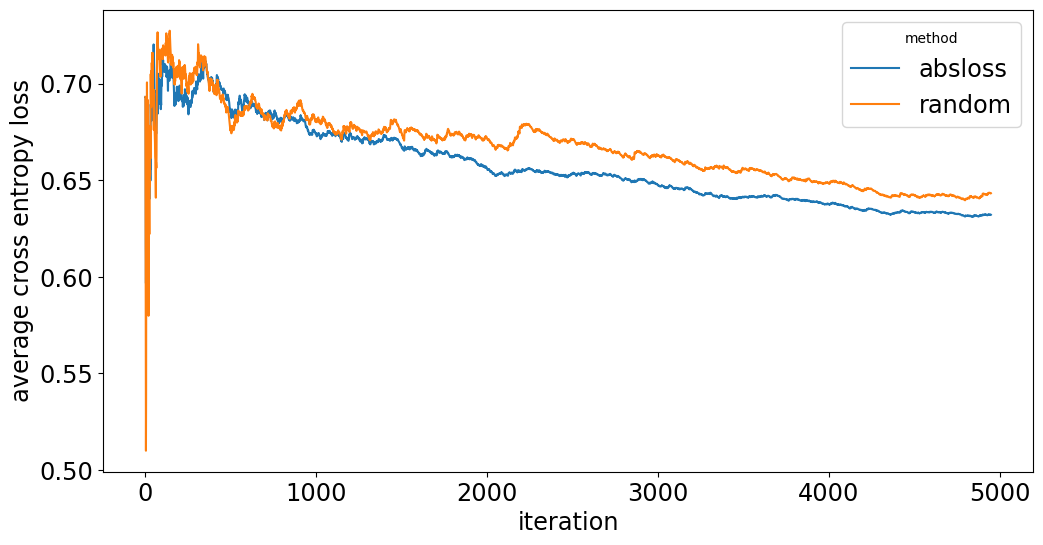

In [141]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_train_loss",
    hue="method"
)

ax.set_ylabel("average cross entropy loss")
#ax.set_xlim((0, 6499))

#plt.xscale('log')
#plt.yscale('log')

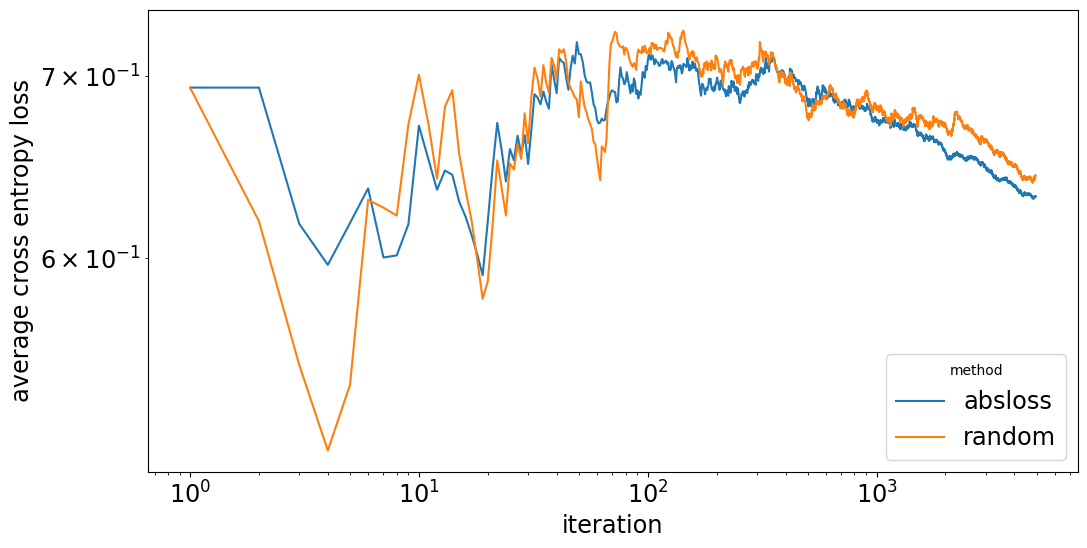

In [142]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_train_loss",
    hue="method"
)

ax.set_ylabel("average cross entropy loss")
#ax.set_xlim((0, 6499))

plt.xscale('log')
plt.yscale('log')

# Plot 1: train loss of rand vs Polyak exponent 
First run for various Polyak exponent values, and the run for rand for matching pz

- mean train loss curve
- mean test loss curve
- accuracy

For a single instance, polyak exponent method does:

pz = zeta ** polyakexponent

We aim to control the mean of pz across the dataset. 
we can find approximate solutions by taking zeta to be constant.

mean_pz = c ** polyakexponent

We don't know what c is because it depends on kappa, kappa0, 
and the losses in complex ways. However,  Then we can run the training loop
with polyakexp = 1 and take the empirical mean of the pz values to find our estimate for c.

Now we can find estimates of the polyakexp values that will lead to any desired mean_pz a using:

a = c ** polyakexp
log(a) = log(c ** ployakexp)
log(a) = ployakexp * log(c)
polyakexp = log(a) / log(c)

In practice, c is not a constant, but we instead have an instance-specific zeta.
As a result, it is likely that when we use this to derive this equation that gives us a value of polyakexp
for a desired sampling probability a, that the empirical mean sampling probability somewhat deviates that.

This is OK, since we're not looking to control pz precisely. Rather, we are looking to verify that polyak exponent
is more efficient than random sampling even in scenarios where we sample. We are simply looking to cover a wide range
of sampling probabilities.

To achieve a fair comparison against random sampling, we will calculate the empirical pz of the polyak exponent runs under a
and then run a random sampling under the same probability.

In [143]:
polyak_exponent_params = hyperparam_per_algo["polyak_exponent"]

polyakexp_1_results = train_model(
    X, y, Xtest, ytest, mode="polyak_exponent", **(polyak_exponent_params | {"polyakexp": 1})
)

c = np.mean(polyakexp_1_results["probs"])

Training with algorithm polyak_exponent: 4948 iterations with d=166
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.7280426619218204, train loss: 0.7929393176088979, ||theta||_1: 0.6587886016015112 acc: 0.0
loss: 0.7155335383885149, train loss: 0.6129780458533779, ||theta||_1: 1.0152690887192002 acc: 1.0
loss: 0.6898735834008263, train loss: 1.2240677566423959, ||theta||_1: 1.2325045897982352 acc: 0.0
loss: 0.6898735834008263, train loss: 0.7418076701475467, ||theta||_1: 1.2325045897982352 acc: 0.0
loss: 0.6867259554954286, train loss: 0.7222935668572728, ||theta||_1: 1.5444591616137409 acc: 0.0
loss: 0.6865558304083618, train loss: 0.9161311982881339, ||theta||_1: 1.760928469403611 acc: 0.0
loss: 0.7233986299167496, train loss: 0.626856706526562, ||theta||_1: 1.6414597847401535 acc: 1.0
loss: 0.7438905757395348, train loss: 0.35476212935599083, ||theta||_1: 1.9798171593944434 acc: 1.0
loss: 0.7193318810012712, train loss: 0.4900042578202196,

loss: 0.7424107007500091, train loss: 3.4730348027999183, ||theta||_1: 8.685258256035112 acc: 0.0
loss: 0.7492353192290635, train loss: 0.017189003252719173, ||theta||_1: 8.753227958988187 acc: 1.0
loss: 0.7543959855277547, train loss: 0.9213281743249039, ||theta||_1: 8.876577634201453 acc: 0.0
loss: 0.7765856848694302, train loss: 1.5875784976970178, ||theta||_1: 9.034364674310151 acc: 0.0
loss: 0.7785862592167775, train loss: 1.4451457077921002, ||theta||_1: 9.069299689598125 acc: 0.0
loss: 0.7906863102830011, train loss: 0.14813543377442162, ||theta||_1: 9.186533904422099 acc: 1.0
loss: 0.8146018307375181, train loss: 0.08409223482337969, ||theta||_1: 9.21318588888299 acc: 1.0
loss: 0.8111041332695025, train loss: 0.26467274457956, ||theta||_1: 9.271773975680672 acc: 1.0
loss: 0.8280831063190257, train loss: 0.1359133269258788, ||theta||_1: 9.362254304257783 acc: 1.0
loss: 0.8356206639346503, train loss: 0.10319010676072758, ||theta||_1: 9.512726386788065 acc: 1.0
loss: 0.7672476062

loss: 0.7826179926928322, train loss: 0.3190513469516592, ||theta||_1: 11.639906525802807 acc: 1.0
loss: 0.7947321490554485, train loss: 0.034587255576913695, ||theta||_1: 11.767501727183447 acc: 1.0
loss: 0.7065822886132608, train loss: 0.08106560337340578, ||theta||_1: 11.500407985056484 acc: 1.0
loss: 0.7082525831776788, train loss: 1.2638138792354932, ||theta||_1: 11.520296757188781 acc: 0.0
loss: 0.6994405220180497, train loss: 3.0001665033296985, ||theta||_1: 11.52034279686927 acc: 0.0
loss: 0.6988600081036792, train loss: 0.09188531166799613, ||theta||_1: 11.521460112884363 acc: 1.0
loss: 0.6956589602623225, train loss: 0.8951406468373166, ||theta||_1: 11.295708353968008 acc: 0.0
loss: 0.6970124349325826, train loss: 0.050396418469484554, ||theta||_1: 11.379676259859405 acc: 1.0
loss: 0.6957127071190933, train loss: 2.062154467178738, ||theta||_1: 11.43518170269382 acc: 0.0
loss: 0.6969959081417811, train loss: 0.1264517587336432, ||theta||_1: 11.598586261341119 acc: 1.0
loss: 0

loss: 0.7212033462486177, train loss: 0.49384927657989397, ||theta||_1: 12.633196059466401 acc: 1.0
loss: 0.7086452137233703, train loss: 1.058007092307941, ||theta||_1: 12.678363965318042 acc: 0.0
loss: 0.6461724508404054, train loss: 0.17250242930236195, ||theta||_1: 12.516545762542073 acc: 1.0
loss: 0.6422128256082478, train loss: 0.6791676803940021, ||theta||_1: 12.453556039252605 acc: 1.0
loss: 0.6515521540990057, train loss: 0.038253229020751005, ||theta||_1: 12.437937864681631 acc: 1.0
loss: 0.6542517383656212, train loss: 0.6356135036561983, ||theta||_1: 12.548524802694619 acc: 1.0
loss: 0.6669798422974258, train loss: 0.001665979074890872, ||theta||_1: 12.629739610881158 acc: 1.0
loss: 0.6985126091511443, train loss: 0.14401503757658113, ||theta||_1: 12.771449855300897 acc: 1.0
loss: 0.6973327384570821, train loss: 0.13216425838365226, ||theta||_1: 12.829176850913552 acc: 1.0
loss: 0.7100712280903507, train loss: 0.0173939073724178, ||theta||_1: 12.91712901391993 acc: 1.0
loss

In [144]:
# We're aiming to achieve sampling probabilities <0.1, 0.2, ..., 1.0>
#target_pzs = [0.1 * i for i in range(1, 11)]
target_pzs = [0.01, 0.1, 0.25, 0.5]
polyak_exps = [math.log(a) / math.log(c) for a in target_pzs]
polyak_exps

[4.873404705981273, 2.4367023529906366, 1.4670409975103682, 0.7335204987551841]

In [145]:
polyak_exponent_params = hyperparam_per_algo["polyak_exponent"]

polyak_exponent_results = {
    f"polyak_exponent_{polyak_exp:.1f}": train_model(
        X, y, Xtest, ytest, mode="polyak_exponent", verbose=False, **(polyak_exponent_params | {"polyakexp": polyak_exp})
    )
    for polyak_exp in polyak_exps
}

In practice, c is not a constant, but we instead have an instance-specific zeta that depends on kappa, kappa0, and the losses in complex ways.
As a result, it is likely that the empirical mean sampling probabilities somewhat deviate from our targets target_pzs.

We now calculate the empirical pzs of these polyak exponent runs.

In [146]:
empirical_pzs = []
for key in polyak_exponent_results.keys():
    empirical_pzs += [np.mean(polyak_exponent_results[key]["probs"])]

In [147]:
empirical_pzs

[0.24100489229559163,
 0.3515498819715328,
 0.30897393391585914,
 0.45549845897543767]

In [148]:
rand_params = hyperparam_per_algo["random"]

rand_results = {
    f"random_{polyak_exp:.1f}": train_model(
        X, y, Xtest, ytest, mode="random", verbose=False, **(rand_params | {"pz0": empirical_pz})
    )
    for polyak_exp, empirical_pz in zip(polyak_exps, empirical_pzs)
}

In [149]:
plot1_df = results_to_df((rand_results | polyak_exponent_results))
plot1_df[['method', 'polyak_exp']] = plot1_df['method'].str.rsplit('_', n=1, expand=True)

In [150]:
plot1_df.groupby(["method", "polyak_exp", "probs"]).train_loss.mean()

method           polyak_exp  probs   
polyak_exponent  0.7         0.110982     0.837862
                             0.124738     1.080192
                             0.130061     0.432082
                             0.130129     2.948804
                             0.131536     2.155805
                                           ...    
                 4.9         0.598419    12.353734
random           0.7         0.455498     0.645340
                 1.5         0.308974     0.664434
                 2.4         0.351550     0.663835
                 4.9         0.241005     0.650626
Name: train_loss, Length: 14345, dtype: float64

In [151]:
plot1_df.groupby(["method", "polyak_exp", "probs"]).mean_train_loss.min()

method           polyak_exp  probs   
polyak_exponent  0.7         0.110982    0.722594
                             0.124738    0.707550
                             0.130061    0.700182
                             0.130129    0.698470
                             0.131536    0.707979
                                           ...   
                 4.9         0.598419    0.692485
random           0.7         0.455498    0.589136
                 1.5         0.308974    0.575097
                 2.4         0.351550    0.584766
                 4.9         0.241005    0.596643
Name: mean_train_loss, Length: 14345, dtype: float64

Polyak exp value 4.9 has rows (9896, 16)
Polyak exp value 2.4 has rows (9896, 16)
Polyak exp value 1.5 has rows (9896, 16)
Polyak exp value 0.7 has rows (9896, 16)


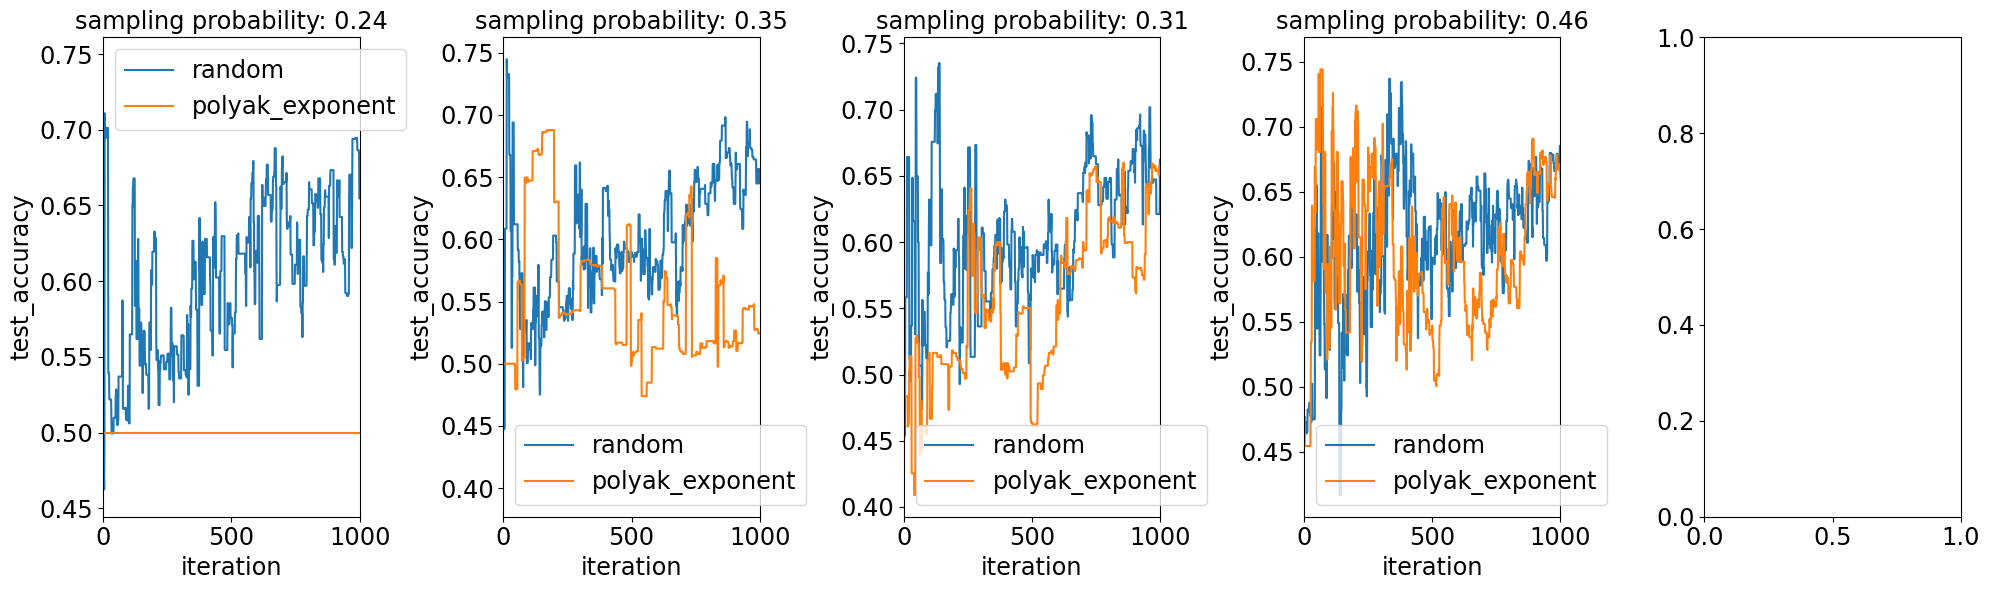

In [152]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]#[i // 5][i % 5]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="test_accuracy", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    ax.set_xlim((0, 1000))
    
    i+=1
f.tight_layout()

Polyak exp value 4.9 has rows (9896, 16)
Polyak exp value 2.4 has rows (9896, 16)
Polyak exp value 1.5 has rows (9896, 16)
Polyak exp value 0.7 has rows (9896, 16)


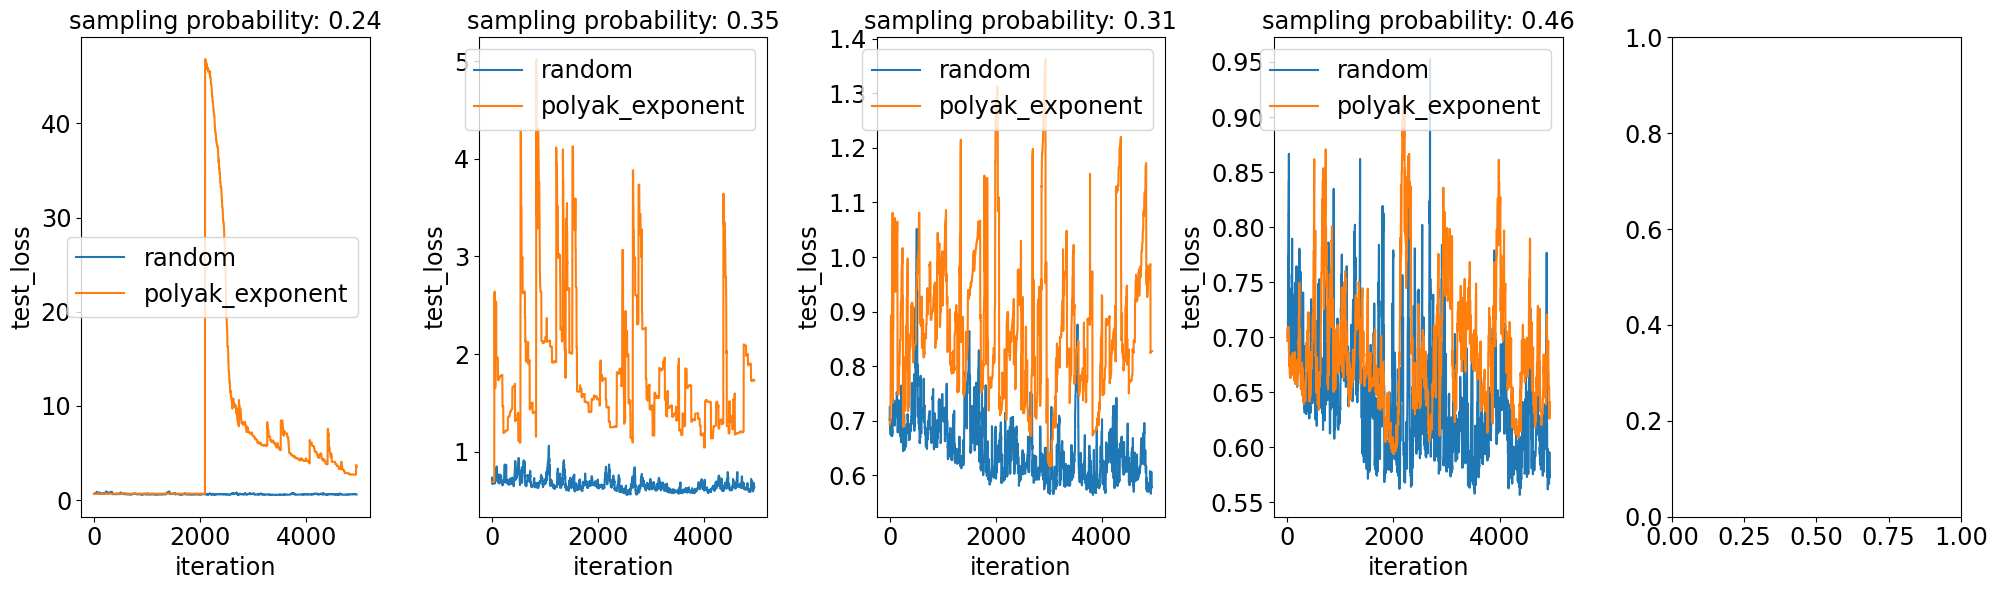

In [153]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    #ax.set_ylim((0.63, 0.7))
    
    i+=1
f.tight_layout()

In [154]:
plot1_df["method"] = [method if method != "polyak_exponent" else "polyak_power_function" for method in plot1_df.method]

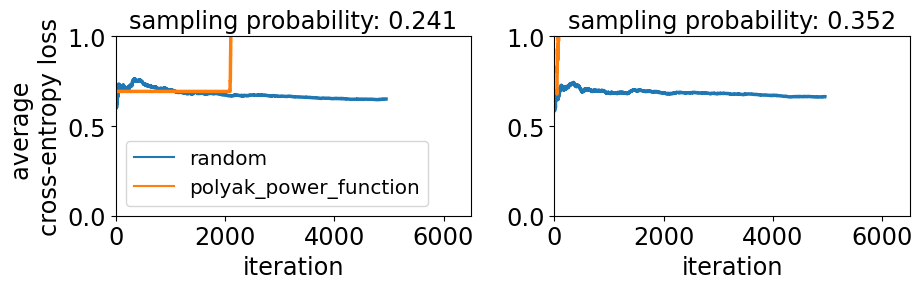

In [155]:
f, axs = plt.subplots(1, 2, figsize=(9.5, 3.0))
i = 0
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

for polyak_exp, pz in zip(polyak_exps[:2], empirical_pzs[:2]):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_train_loss", 
        hue="method",
        ax=ax,
        linewidth=2.5
    )
    
    ax.set_title(f"sampling probability: {pz:.3f}")
    ax.legend()
    ax.set_ylim((0.00, 1))
    ax.set_xlim((0, 6499))
    #ax.set_xlim((0, 6000))
    
    i+=1
    
axs[0].set_ylabel("average \ncross-entropy loss")
axs[1].set_ylabel("")

axs[1].get_legend().remove()

f.tight_layout()

plt.savefig(f"figure_2_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

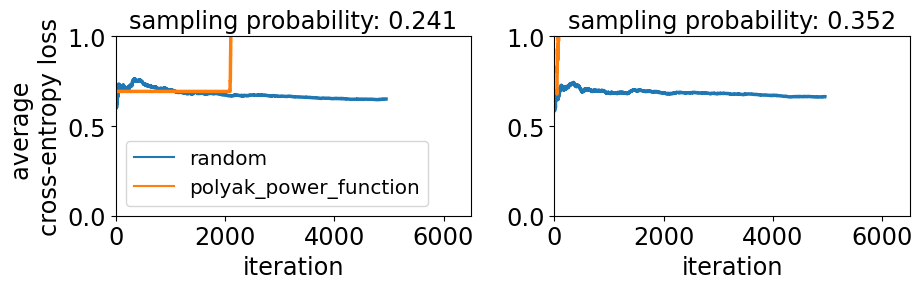

In [156]:
f, axs = plt.subplots(1, 2, figsize=(9.5, 3.0))
i = 0
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

for polyak_exp, pz in zip(polyak_exps[:2], empirical_pzs[:2]):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_train_loss", 
        hue="method",
        ax=ax,
        linewidth=2.5
    )
    
    ax.set_title(f"sampling probability: {pz:.3f}")
    ax.legend()
    ax.set_ylim((0.00, 1))
    ax.set_xlim((0, 6499))
    #ax.set_xlim((0, 6000))
    
    i+=1
    
axs[0].set_ylabel("average \ncross-entropy loss")
axs[1].set_ylabel("")

axs[1].get_legend().remove()

f.tight_layout()

plt.savefig(f"figure_2_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

0.24100489229559163
Polyak exp value 4.9 has rows (9896, 16)
0.3515498819715328
Polyak exp value 2.4 has rows (9896, 16)
0.30897393391585914
Polyak exp value 1.5 has rows (9896, 16)
0.45549845897543767
Polyak exp value 0.7 has rows (9896, 16)


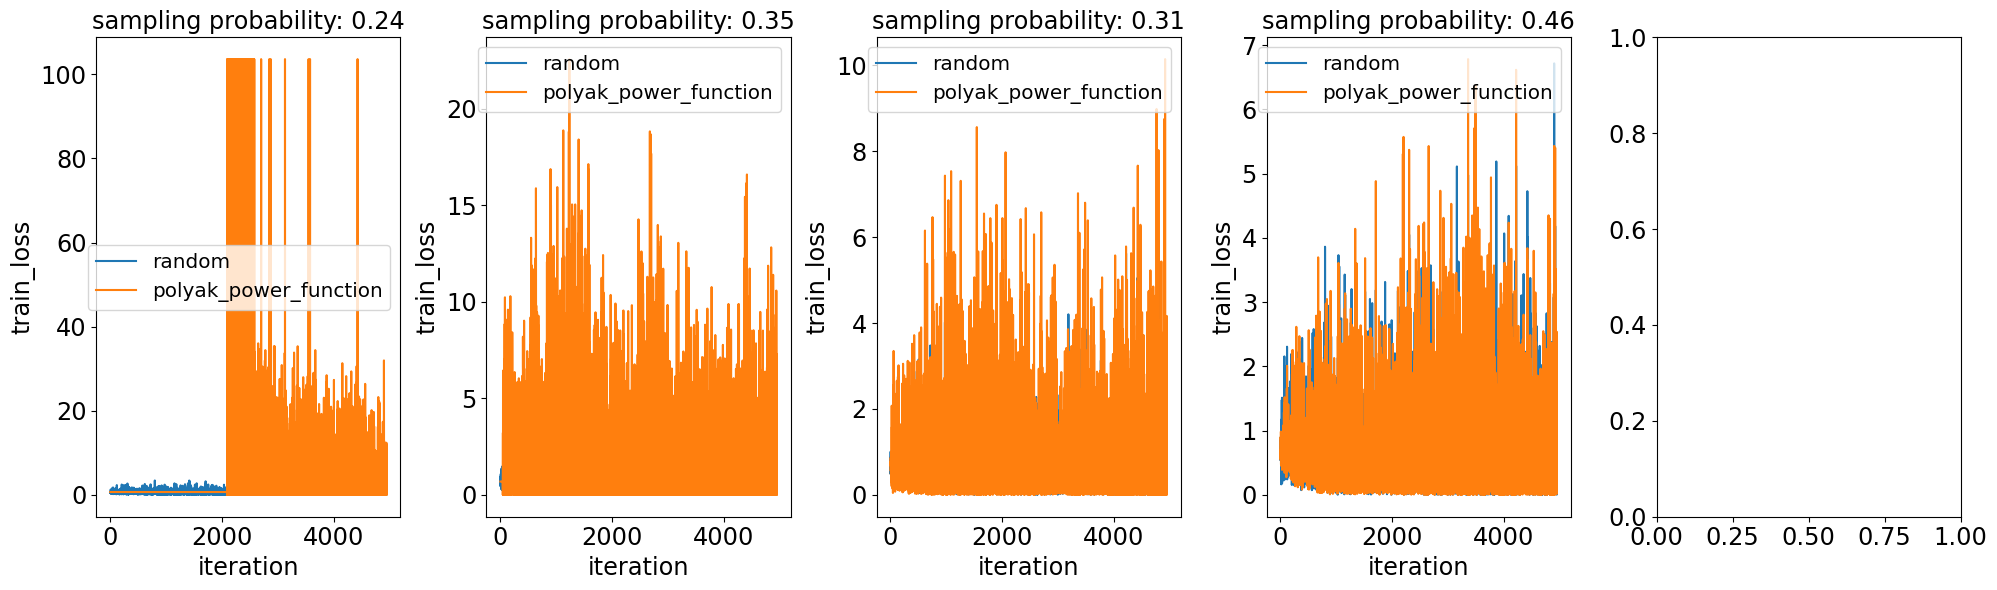

In [157]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(pz)
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="train_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    
    i+=1
f.tight_layout()

0.24100489229559163
Polyak exp value 4.9 has rows (9896, 16)
0.3515498819715328
Polyak exp value 2.4 has rows (9896, 16)
0.30897393391585914
Polyak exp value 1.5 has rows (9896, 16)
0.45549845897543767
Polyak exp value 0.7 has rows (9896, 16)


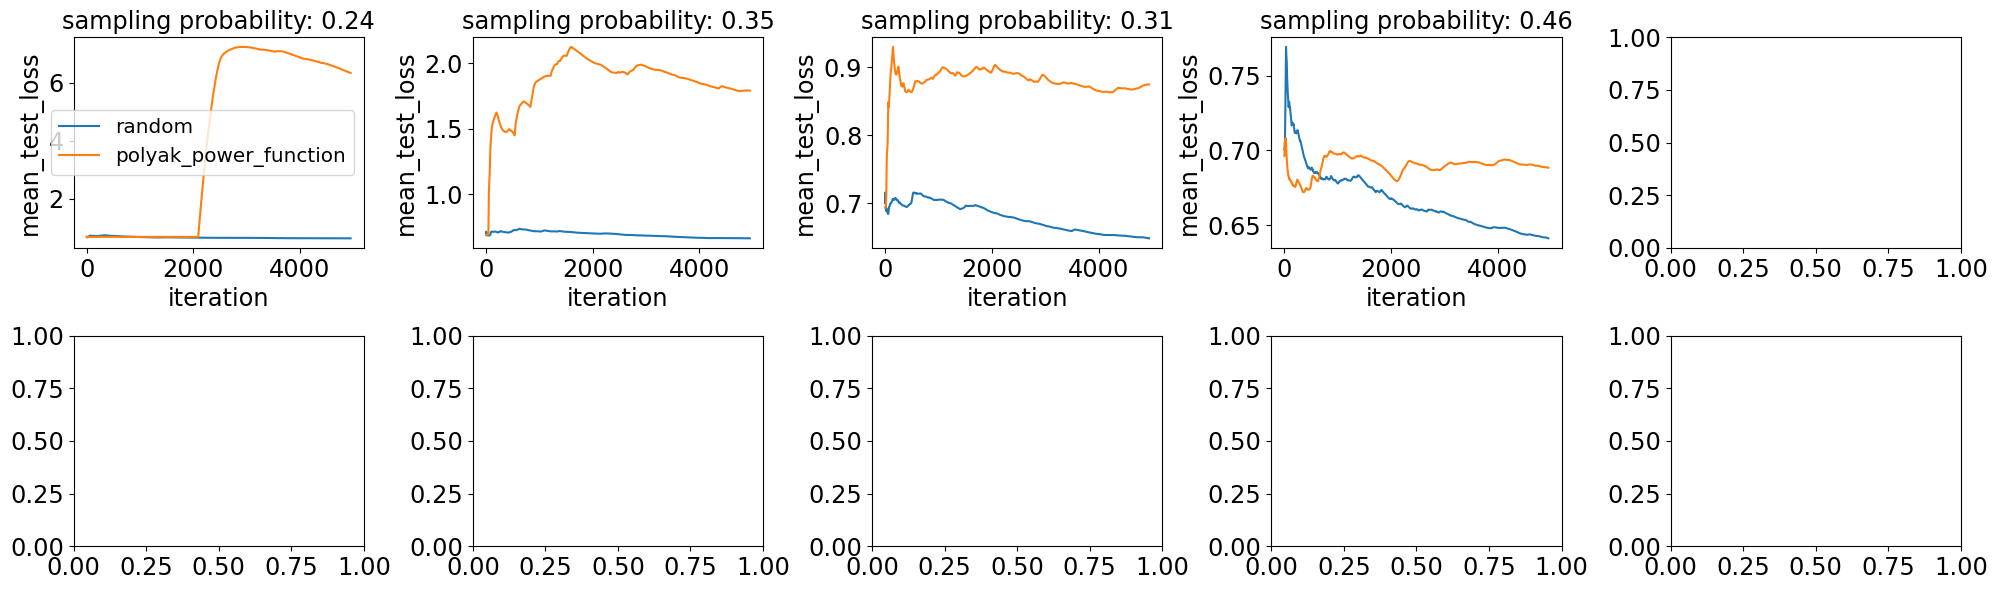

In [158]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
handles, labels = [], []

i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(pz)
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    if i == 0:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    else:
        ax.get_legend().remove()
    
    i+=1
f.tight_layout()

# Plot 2: Polyak absloss vs absloss
First run absloss, then we run Polyak absloss with omega=1 with yields the same sampling probability

- mean train loss curve
- mean test loss curve
- accuracy

In [159]:
hyperparam_per_algo["polyak_absloss"]

{'kappa': 10, 'kappa0': 0.9, 'eta': 0.01, 'omega': 1.0}

In [160]:
results_polyak_absloss = train_model(
    X, y, Xtest, ytest, mode="polyak_absloss", verbose=True, 
    #**(hyperparam_per_algo["polyak_absloss"] | {"omega": 1})
    **hyperparam_per_algo["polyak_absloss"]
)

Training with algorithm polyak_absloss: 4948 iterations with d=166
loss: 0.6946545010074012, train loss: 0.6931471805599453, ||theta||_1: 0.2780435539049437 acc: 0.5
loss: 0.7022557972916927, train loss: 0.630412639389946, ||theta||_1: 0.4584039515177243 acc: 1.0
loss: 0.7096549843797124, train loss: 0.7189795094107599, ||theta||_1: 0.7410802943832973 acc: 0.0
loss: 0.6948626167494617, train loss: 0.8498602857858404, ||theta||_1: 0.9406780947758371 acc: 0.0
loss: 0.6898251280150836, train loss: 0.5866204049674959, ||theta||_1: 0.8527766275330955 acc: 1.0
loss: 0.6889493911769539, train loss: 0.5872402671149247, ||theta||_1: 0.9398617998400751 acc: 1.0
loss: 0.6775807403591184, train loss: 0.5854084533914683, ||theta||_1: 1.370423669790397 acc: 1.0
loss: 0.6793775264130262, train loss: 0.9650118702833643, ||theta||_1: 1.0557380370138398 acc: 0.0
loss: 0.6781757209255334, train loss: 0.5954726339549485, ||theta||_1: 1.073075312929069 acc: 1.0
loss: 0.7022475492430942, train loss: 0.57574

loss: 0.7129635518290526, train loss: 0.11223938070566815, ||theta||_1: 7.974229066212835 acc: 1.0
loss: 0.7266021296974163, train loss: 1.33817104942862, ||theta||_1: 8.060492139853523 acc: 0.0
loss: 0.701753391832788, train loss: 1.159412699865452, ||theta||_1: 7.782554901172525 acc: 0.0
loss: 0.6740183613020381, train loss: 1.8675173776565381, ||theta||_1: 7.505668472119704 acc: 0.0
loss: 0.6593669625251974, train loss: 1.1687960612748305, ||theta||_1: 7.2412496616995 acc: 0.0
loss: 0.64876457583577, train loss: 0.05085151053712981, ||theta||_1: 7.213137944878392 acc: 1.0
loss: 0.6391958509043593, train loss: 0.09452994157369939, ||theta||_1: 7.171129315058388 acc: 1.0
loss: 0.6379628150999862, train loss: 1.297992756431059, ||theta||_1: 7.108908075300786 acc: 0.0
loss: 0.6402855383524935, train loss: 1.292399350144888, ||theta||_1: 7.234337804439018 acc: 0.0
loss: 0.6311272013866785, train loss: 0.8854662438474832, ||theta||_1: 7.144215752695392 acc: 0.0
loss: 0.646704560713601, tr

loss: 0.6511033388331958, train loss: 0.11878673035269884, ||theta||_1: 9.58909339522591 acc: 1.0
loss: 0.6400920543670969, train loss: 1.2739436886339588, ||theta||_1: 9.57266191021348 acc: 0.0
loss: 0.693359366256893, train loss: 0.10323223480224299, ||theta||_1: 10.091552383099414 acc: 1.0
loss: 0.7044523456933924, train loss: 0.7290452627623007, ||theta||_1: 10.081476208306643 acc: 0.0
loss: 0.6799247279546649, train loss: 1.0036575836421173, ||theta||_1: 9.95633970365787 acc: 0.0
loss: 0.6543743965774272, train loss: 0.8196046133676314, ||theta||_1: 9.795116304598727 acc: 0.0
loss: 0.6558020250994945, train loss: 0.47201416752639974, ||theta||_1: 9.785187342172271 acc: 1.0
loss: 0.658820483966329, train loss: 1.174155051435513, ||theta||_1: 9.83193398847738 acc: 0.0
loss: 0.6504478703411518, train loss: 0.4353791996590338, ||theta||_1: 9.767813483549656 acc: 1.0
loss: 0.6553672624273055, train loss: 0.386202686942599, ||theta||_1: 9.699482791998914 acc: 1.0
loss: 0.649984752540271

loss: 0.6391402755598288, train loss: 1.0378768105664145, ||theta||_1: 11.97111662025098 acc: 0.0
loss: 0.6972849365598869, train loss: 0.3518949031409603, ||theta||_1: 12.208767922416094 acc: 1.0
loss: 0.6800791136955828, train loss: 0.8069833652571434, ||theta||_1: 12.191519153455223 acc: 0.0
loss: 0.6771347778595133, train loss: 0.08946957596076854, ||theta||_1: 12.083502665094628 acc: 1.0
loss: 0.6663488603239173, train loss: 0.02326195240092832, ||theta||_1: 12.129232659319532 acc: 1.0
loss: 0.662333409396416, train loss: 0.3540876214778204, ||theta||_1: 12.153697668111207 acc: 1.0
loss: 0.6521013260247793, train loss: 0.007534108170030028, ||theta||_1: 12.082636254353972 acc: 1.0
loss: 0.6488013799693569, train loss: 0.12748478215189188, ||theta||_1: 12.082702812258411 acc: 1.0
loss: 0.659781571990482, train loss: 0.26894207715312174, ||theta||_1: 12.030617681939034 acc: 1.0
loss: 0.6574179121789381, train loss: 0.23063088781642924, ||theta||_1: 11.993291018639042 acc: 1.0
loss: 

In [161]:
hppa = hyperparam_per_algo["polyak_absloss"]
hppa["omega"] *= np.mean(results_absloss["probs"]) / np.mean(results_polyak_absloss["probs"])
hyperparam_per_algo["polyak_absloss"] = hppa
print(hppa)

{'kappa': 10, 'kappa0': 0.9, 'eta': 0.01, 'omega': 1.0741457196713322}


In [162]:
plot2_df = results_to_df(
    {
        "absloss": results_absloss,
        "polyak_absloss": results_polyak_absloss,
    }
)

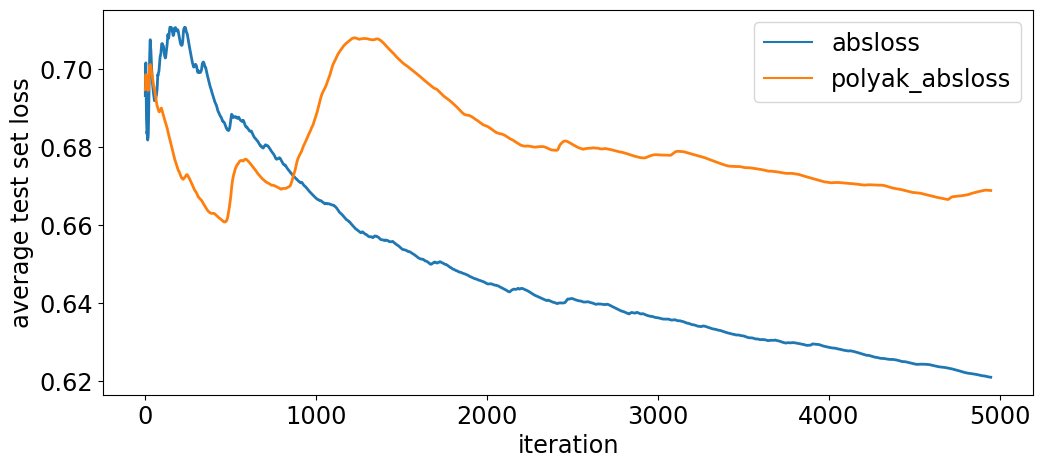

In [163]:
plt.figure(figsize=(12,5))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

ax = sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_test_loss",
    hue="method",
    linewidth=2
)

legend = ax.get_legend()
legend.set_title('')

ax.set(ylabel="average test set loss")

plt.savefig(f"figure_7b_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

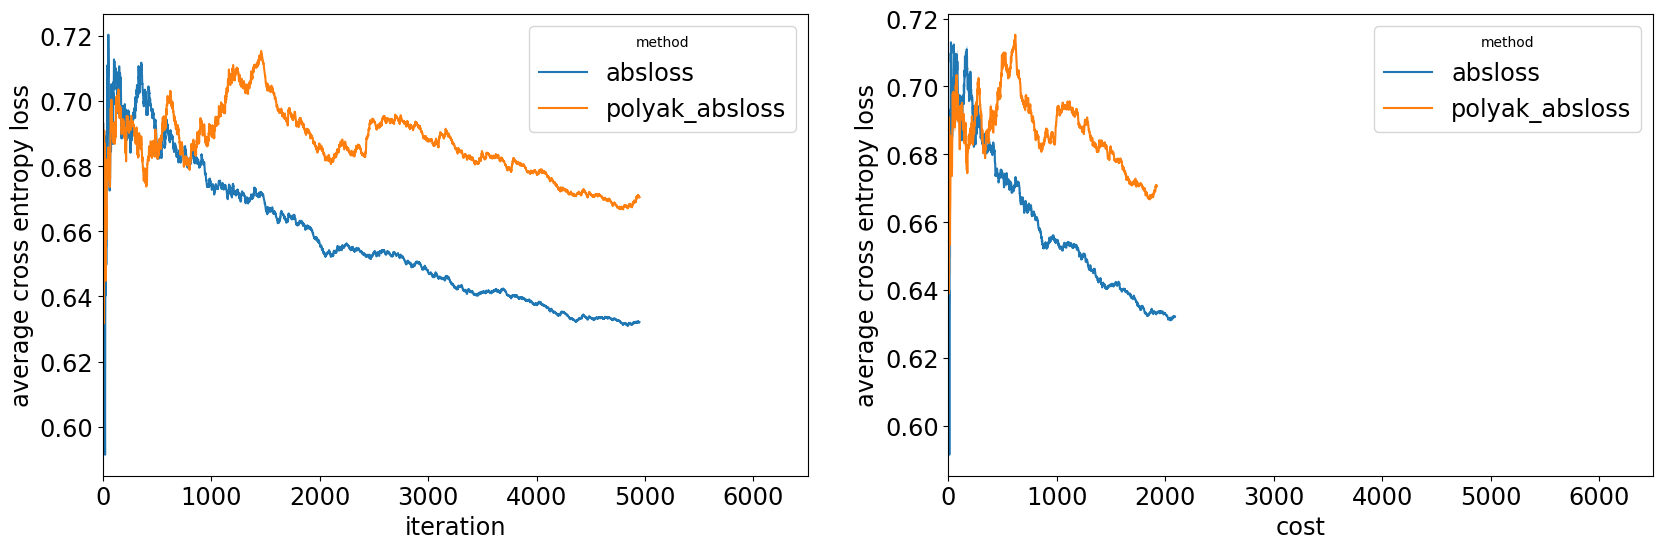

In [164]:
f, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    ax=axs[0]
)

sns.lineplot(
    data=plot2_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel("average cross entropy loss")
    axs[i].set_xlim((0, 6499))

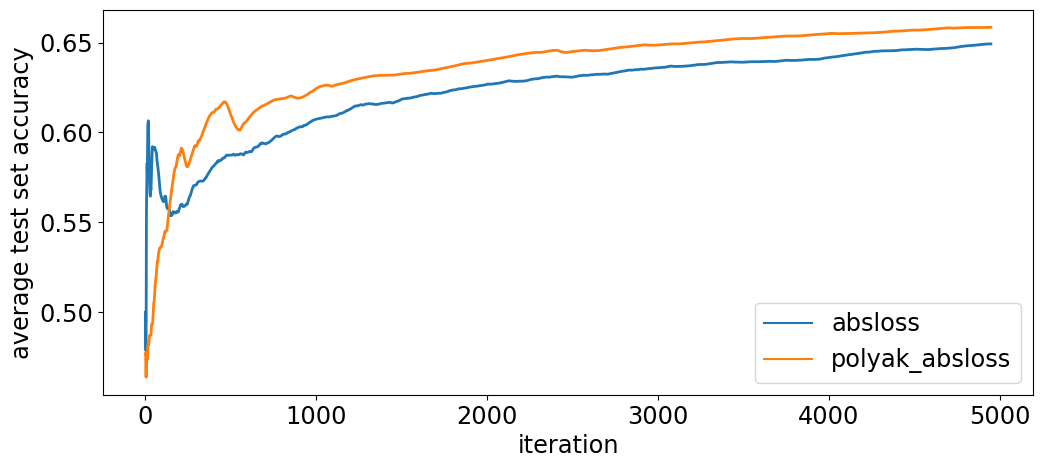

In [165]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12,5))

ax = sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_test_accuracy",
    hue="method",
    linewidth=2
)

ax.set(ylabel="average test set accuracy")

legend = ax.get_legend()
legend.set_title('')

plt.savefig(f"figure_8b_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

In [166]:
plot02_df = results_to_df(
    {
        "random": results_rand,
        "absloss": results_absloss,
        "polyak_absloss": results_polyak_absloss
    }
)

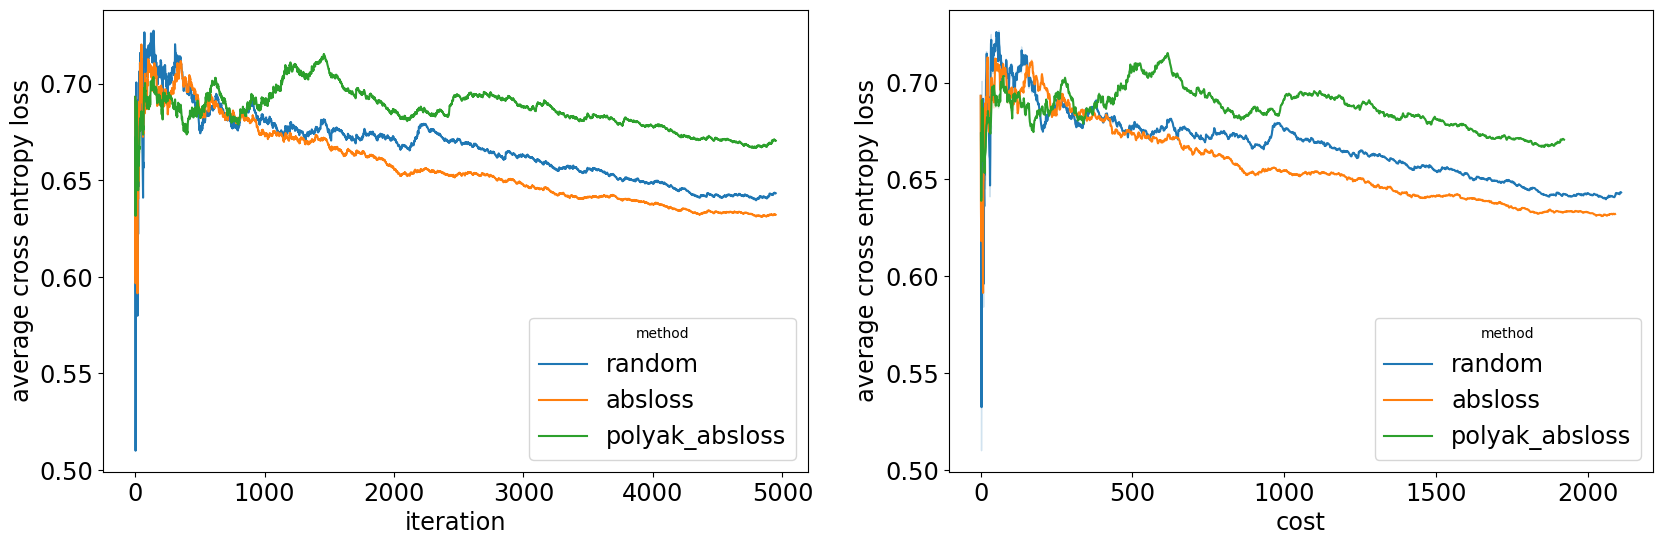

In [167]:
f, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(
    data=plot02_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    ax=axs[0]
)

sns.lineplot(
    data=plot02_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel("average cross entropy loss")

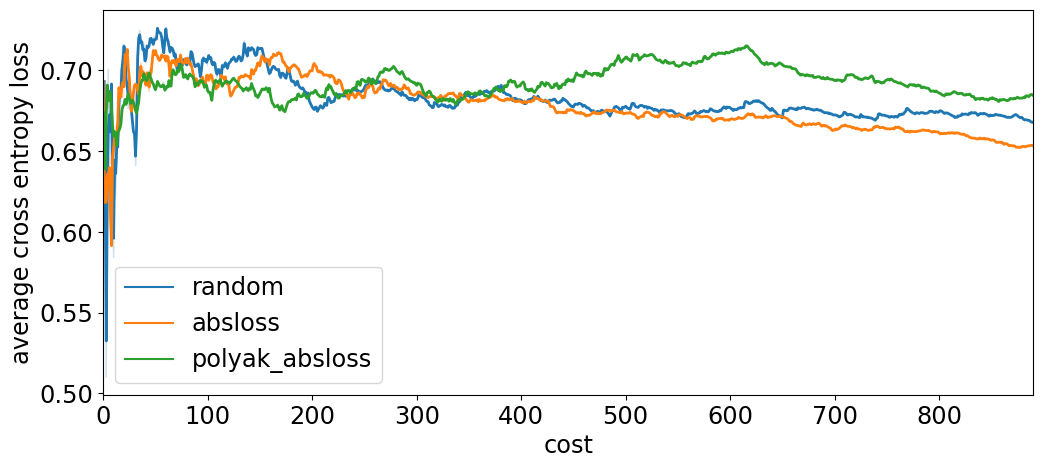

In [168]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12,5))

ax = sns.lineplot(
    data=plot02_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    linewidth=2
)

ax.set(ylabel="average cross entropy loss")
ax.set_xlim((0, 890))

legend = ax.get_legend()
legend.set_title('')

plt.savefig(f"figure_6_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

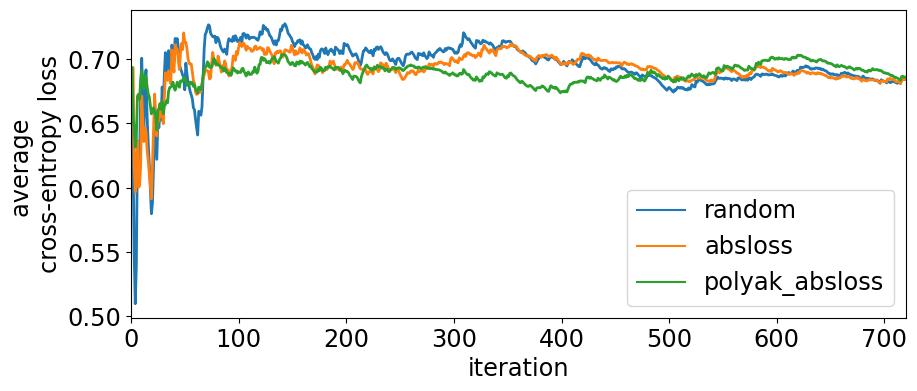

In [169]:
plt.figure(figsize=(10,4))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

ax = sns.lineplot(
    data=plot02_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    linewidth=2
)
legend = ax.get_legend()
legend.set_title('')
ax.set_xlim((0, 720))

ax.set(ylabel="average \ncross-entropy loss")

plt.savefig(f"figure_3_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")
